In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
number_of_rows_per_language = 500
languages = ['Polish', 'Slovak', 'French', 'English', 'German', 'Finnish', 'Hungarian']

train_set = pd.DataFrame()
test_set = pd.DataFrame()

for language in languages:
    data = pd.read_csv(f'data/processed/{language}.csv', nrows=number_of_rows_per_language)
    train_data = data.sample(frac=.85)
    test_data = data.drop(index=train_data.index)

    train_set = pd.concat([train_set, train_data], ignore_index=True)
    test_set = pd.concat([test_set, test_data], ignore_index=True)

train_set.head()

,text,lang,letters,a,b,c,d,e,f,g,...,q,r,s,t,u,v,w,x,y,z
0,"Sella też urodziła Tubalkaina, rzemieślnika ws...",Polish,sellateżurodziłatubalkainarzemieślnikawszelkie...,15,4,0,4,9,0,0,...,0,4,4,5,3,0,2,0,2,5
1,"Tedy rzekł Bóg: To jest znak przymierza, który...",Polish,tedyrzekłbógtojestznakprzymierzaktóryjadawammi...,10,1,2,8,8,0,1,...,0,6,3,6,1,0,6,0,7,11
2,"A była Saraj niepłodna, i nie miała dziatek.\n",Polish,abyłasarajniepłodnainiemiaładziatek,8,1,0,2,3,0,0,...,0,1,1,1,0,0,0,0,1,1
3,"Selech zaś żył trzydzieści lat, i spłodził Heb...",Polish,selechzaśżyłtrzydzieścilatispłodziłhebera,3,1,2,2,5,0,0,...,0,2,2,2,0,0,0,0,2,4
4,"Ci trzej synowie Noego, przez które się napełn...",Polish,citrzejsynowienoegoprzezktóresięnapełniłaludem...,4,0,1,1,8,0,1,...,0,3,4,3,1,0,2,0,2,5


In [3]:
train_set.drop(columns=['text', 'letters'], inplace=True)

In [4]:
language_to_code = {lang: code for code, lang in enumerate(languages)}
language_to_code

{'Polish': 0,
 'Slovak': 1,
 'French': 2,
 'English': 3,
 'German': 4,
 'Finnish': 5,
 'Hungarian': 6}

In [5]:
train_set['code'] = train_set.lang.map(lambda x: language_to_code[x])
test_set['code'] = test_set.lang.map(lambda x: language_to_code[x])

In [6]:
class Perceptron:
    def __init__(self, number_of_inputs: int, learning_rate: float):
        self.weights_vector = np.random.random(number_of_inputs)
        self.theta = np.random.random()
        self.alpha = learning_rate

    def predict(self, vector: np.ndarray, return_net: bool=False):
        net = np.sum(self.weights_vector * vector) - self.theta

        if return_net:
            return net

        return int(net > 0)


    def train(self, vector: np.ndarray, expected_outcome: int) -> None:
        extended_weights = np.append(self.weights_vector, self.theta)
        extended_vector = np.append(vector, -1)

        new_weights = extended_weights + (expected_outcome - self.predict(vector)) * self.alpha * extended_vector
        self.theta = new_weights[-1]
        self.weights_vector = new_weights[:-1]

    def __str__(self) -> str:
        return f'weights={self.weights_vector}; theta={self.theta}'

In [7]:
class SingleLayerNeuralNetwork:
    def __init__(self, number_of_categories: int, number_of_inputs: int, learning_rate: float):
        self.perceptrons = [Perceptron(number_of_inputs, learning_rate) for _ in range(number_of_categories)]

    def predict(self, X: np.ndarray):
        scores = [p.predict(X, return_net=True) for p in self.perceptrons]
        return np.argmax(scores)

    def train(self, vector: np.ndarray, expected_outcome: int):
        for index, perceptron in enumerate(self.perceptrons):
            perceptron.train(vector, int(expected_outcome == index))

In [8]:
class NN:
    def __init__(self, inputs: int, categories: int, learning_rate: float):
        self.inputs = inputs
        self.categories = categories
        self.weights : np.ndarray = np.random.random((inputs, categories))
        self.t = np.random.random(categories)
        self.alpha = learning_rate

    def predict(self, x: np.ndarray):
        net = x @ self.weights - self.t
        return np.argmax(net)

    def fit(self, x, y):
        net = x @ self.weights - self.t
        expected_outcomes = np.zeros(self.categories)
        expected_outcomes[y] = 1
        results = (net > 0).astype(int)
        x_matrix = np.tile(x, (self.categories, 1)).transpose()
        x_matrix = np.append(x_matrix,
                             np.array([-1] * self.categories).reshape(1, self.categories),
                             axis=0)
        weights_extended = np.append(self.weights, [self.t], axis=0)

        final = weights_extended + x_matrix @ np.diag((expected_outcomes - results) * self.alpha)
        self.t = final[-1]
        self.weights = final[:-1]



In [9]:
def test_neural_network(nn: SingleLayerNeuralNetwork, data: np.ndarray, expected_values: np.ndarray) -> float:
    results = np.array([])

    for vector in data:
        results = np.append(results, nn.predict(vector))

    return sum(results == expected_values) / len(expected_values)

Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

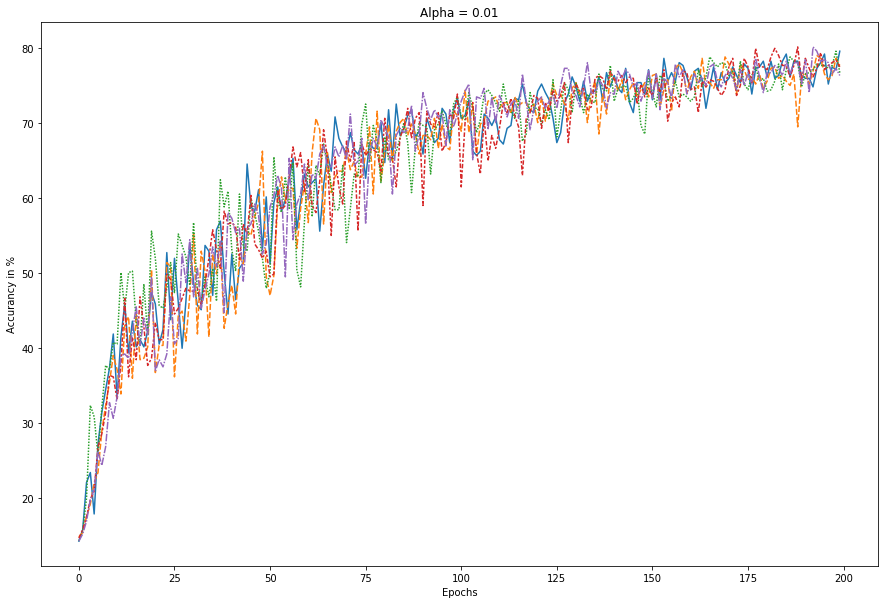

In [10]:
alpha = 0.01
epochs = 200
number_of_iterations = 5

data = train_set.loc[:, 'a':'z'].to_numpy()
expected_values = train_set['code'].to_numpy()

test_data = test_set.loc[:, 'a':'z'].to_numpy()
test_expected_values = test_set['code'].to_numpy()

results = pd.DataFrame(index=range(epochs))
networks = []

for iteration in tqdm(range(number_of_iterations), desc='Iterations'):
    nn = NN(inputs=data.shape[1], categories=len(languages), learning_rate=alpha)

    iteration_results = np.array([])

    for epoch in range(epochs):
        for vector, expected_value in zip(data, expected_values):
            nn.fit(vector, expected_value)

        test_result = test_neural_network(nn, test_data, test_expected_values)
        iteration_results = np.append(iteration_results, test_result * 100)

    networks.append(nn)
    results[iteration] = iteration_results

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.lineplot(data=results, ax=ax)
ax.get_legend().remove()
plt.title(f'Alpha = {alpha}')
plt.xlabel('Epochs')
plt.ylabel('Accurancy in %')
plt.savefig(f'figures/{";".join(languages)}-alpha{alpha}-epochs{epochs}.jpg')
plt.show()

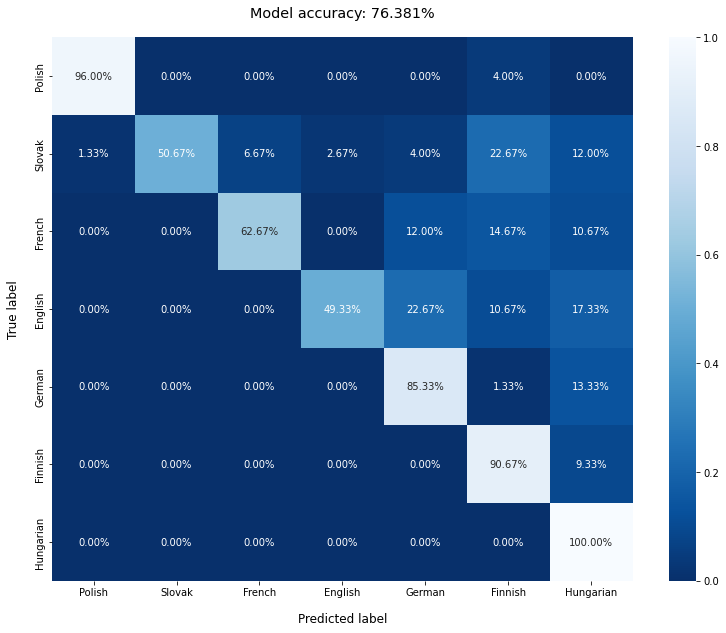

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score

best_network = networks[np.argmax(results.iloc[-1, :])]

y_true = test_expected_values
y_predicted = [nn.predict(x) for x in test_data]

cm = confusion_matrix(y_true, y_predicted, normalize='true')
acc = accuracy_score(y_true, y_predicted)

cmdf = pd.DataFrame(cm)
cmdf.columns = languages
cmdf.index = languages

fig, ax = plt.subplots()
fig.set_size_inches(13, 10)
sns.heatmap(cmdf, annot=True,
                fmt='.2%', cmap='Blues_r', ax=ax)
plt.title(f'Model accuracy: {acc:.3%}', fontsize='x-large', y=1.025)
plt.xlabel('Predicted label', fontsize='large', labelpad=15)
plt.ylabel('True label', fontsize='large', labelpad=15)
plt.show()